In [ ]:
import modern_robotics as mr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [2]:
    # Slist <<    0, 0, 0,
    #             0, -1, -1,
    #             -1, 0, 0,
    #             0, 85.9, 385.9,
    #             0, 0, 0,
    #             0, 0, 0;
    # // // Define the home configuration
    # M(0, 3) = 0; // x
    # M(1, 3) = 30; // y
    # M(2, 3) = 555.9; // z

Slist = np.array([[0, 0, 0],
                  [0, -1, -1],
                  [-1, 0, 0],
                  [0, 85.9, 385.9],
                  [0, 0, 0],
                  [0, 0, 0]])
M = np.array([[1, 0, 0, 0],
              [0, 1, 0, 30],
              [0, 0, 1, 555.9],
              [0, 0, 0, 1]])
thetalist = np.array([0, 0, 0])

Blist = mr.Adjoint(mr.TransInv(M)) @ Slist
print("Blist:   \n", Blist)

def ForwardKinematics(thetalist):
        T = mr.FKinSpace(M, Slist, thetalist)
        return T



Blist:   
 [[   0.    0.    0.]
 [   0.   -1.   -1.]
 [  -1.    0.    0.]
 [  30. -470. -170.]
 [   0.    0.    0.]
 [   0.    0.    0.]]


In [3]:
thetalist = np.array([0, 0, 0]) 
print("=" * 60)
print("Initial End Effector Configuration (all joints at 0):")
print("=" * 60)
T = ForwardKinematics(thetalist)
print(f"Position: x={T[0,3]:.2f}, y={T[1,3]:.2f}, z={T[2,3]:.2f} mm")
# print(f"\nFull Transform Matrix:\n{T}")

print("\n" + "=" * 60)
thetalist = np.array([0, np.pi/4, np.pi/4])
print("End Effector after moving joints 2 & 3 by 45°:")
print("=" * 60)
T = ForwardKinematics(thetalist)
print(f"Position: x={T[0,3]:.2f}, y={T[1,3]:.2f}, z={T[2,3]:.2f} mm")
# print(f"\nFull Transform Matrix:\n{T}")
print("=" * 60)

Initial End Effector Configuration (all joints at 0):
Position: x=0.00, y=30.00, z=555.90 mm

End Effector after moving joints 2 & 3 by 45°:
Position: x=-382.13, y=30.00, z=298.03 mm


In [4]:
def deg_to_rad(degrees):
    return degrees * np.pi / 180.0

def rad_to_deg(radians):
    return radians * 180.0 / np.pi

In [44]:
def IKinBodyLinear(Tsd, thetalist0, ev=1e-2, maxiter=40, step_size=1):
    """Iterative IK that only cares about linear position (ignores orientation).

    Args:
        Tsd: 4x4 desired pose (only translation is used).
        thetalist0: initial guess (n,).
        eomg: unused (kept for API compatibility).
        ev: linear error tolerance (magnitude of position error in the space frame).
        maxiter: max iterations.

    Returns:
        (thetalist, success, iters)
    """
    err_arr = []
    dtheta_arr = []
    thetalist_arr = []
    pos_arr = []

    dxyz_arr = []
    thetalist = thetalist0.astype(float).copy()
    thetalist_arr.append(thetalist.copy())
    current_error_norm = float('inf')
    last_dtheta = np.zeros_like(thetalist)
    for i in range(maxiter):
        T_sb = mr.FKinBody(M, Blist, thetalist)
        p_sb = T_sb[0:3, 3]
        p_sd = Tsd[0:3, 3]
        p_err = p_sd - p_sb  # space-frame position error
        print(f"Iteration {i}: position error = {p_err}, norm = {np.linalg.norm(p_err)}")

        new_error_norm = np.linalg.norm(p_err)
    
        # --- Adaptive Damping Logic ---
        # if i > 0 and new_error_norm > current_error_norm:
        #     print(f"Iteration {i}: Error increased from {current_error_norm} to {new_error_norm}. Reducing step size.")
        #     step_size *= -1  # Reduce step size if error increased
        #     # reverse direction of last step
        #     thetalist = thetalist - last_dtheta * 2
        #     # recompute error after reverting
        #     T_sb = mr.FKinBody(M, Blist, thetalist)
        #     p_sb = T_sb[0:3, 3]
        #     p_err = p_sd - p_sb  # space-frame position error
        #     new_error_norm = np.linalg.norm(p_err)
        #     print(f"Iteration {i}: position error = {p_err}, norm = {np.linalg.norm(p_err)}")

        pos_arr.append(p_sb.copy())
        err_arr.append(p_err.copy())
        
        # err_arr.append(new_error_norm)




        current_error_norm = new_error_norm

        # Convergence check on linear error magnitude
        if new_error_norm < ev:
            # plt.figure()
            # plt.plot(err_arr)
            # # plt.plot(dtheta_arr)
            # # plt.plot(thetalist_arr)
            # # plt.plot(pos_arr)
            # # plt.plot(dxyz_arr)
            # plt.plot()
            # plt.show()
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            err_arr = np.array(err_arr)
            ax.plot(err_arr[:,0], err_arr[:,1], err_arr[:,2], marker='o')
            plt.show()

            return thetalist, True, i

        J = mr.JacobianBody(Blist, thetalist)  # 6xn
        Jv = J[3:, :]  # linear part (3xn)

        # Compute pseudo-inverse of Jv for least-squares step
        Jv_pinv = np.linalg.pinv(Jv)
        dtheta = Jv_pinv @ p_err

        dtheta_arr.append(dtheta)

        thetalist = thetalist + dtheta * step_size  # Dampen step for stability
        last_dtheta = dtheta
        thetalist_arr.append(thetalist.copy())

        # actual change in position
        T_sb_new = mr.FKinBody(M, Blist, thetalist)
        dxyz_arr.append(-(p_sb[0] - T_sb_new[0, 3]))

    plt.figure()
    plt.plot(err_arr)
    # plt.plot(dtheta_arr)
    # plt.plot(thetalist_arr)
    # plt.plot(pos_arr)
    # plt.plot(dxyz_arr)
    plt.show()
    return thetalist, False, maxiter

x-345.92420890719137, y37.38800516653349, z88.67568135664547
Iteration 0: position error = [-1.11658777  7.38800517  0.        ], norm = 7.471906623679949
Iteration 1: position error = [-2.16321304  0.01441039  0.55758088], norm = 2.233963913282476
Iteration 2: position error = [-3.77014562  0.03450004  2.1050926 ], norm = 4.318171269331736
Iteration 3: position error = [-6.06870344  0.04957689  5.74380539], norm = 8.356010991952497
Iteration 4: position error = [-8.8582251   0.0605705  13.58037422], norm = 16.21414149865389
Iteration 5: position error = [-11.33400555   0.05419786  29.56097134], norm = 31.659337421062244
Iteration 6: position error = [-1.20027057e+01  1.47372701e-02  6.13361398e+01], norm = 62.49949764825215
Iteration 7: position error = [-1.05121164e+01 -3.29501888e-02  1.24549006e+02], norm = 124.99184224837738
Iteration 8: position error = [-1.78388890e+01  1.61233285e-01  2.48331862e+02], norm = 248.97181647602864
Iteration 9: position error = [-105.39497501    1.9

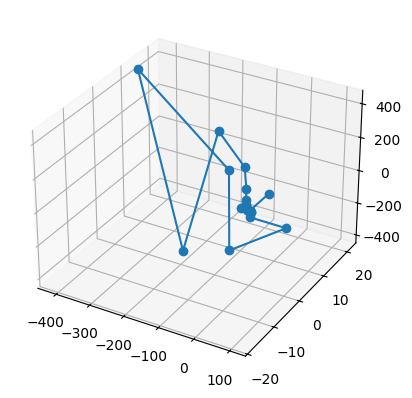

True


In [45]:
thetalist = np.array([0, np.pi/3, np.pi/2]) 
pos = ForwardKinematics(thetalist)

Tsd = np.eye(4)

Tsd[0,3] = pos[0,3] + 25 * np.cos(0.3) - 25
Tsd[1,3] = pos[1,3] + 25 * np.sin(0.3)
Tsd[2,3] = pos[2,3]
print(f"x{Tsd[0,3]}, y{Tsd[1,3]}, z{Tsd[2,3]}")

thetalist,converged, _ = IKinBodyLinear(Tsd, thetalist)
print(converged)

In [7]:
# plot joint angles and end effector path

thetalist_arr = np.array(thetalist_arr)
pos_arr = np.array(pos_arr)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rad_to_deg(thetalist_arr))
plt.title("Joint Angles over Path")
plt.xlabel("Step")
plt.ylabel("Joint Angles (degrees)")
plt.legend([f"Joint {i+1}" for i in range(thetalist_arr.shape[1])])
plt.grid()  
plt.subplot(1, 2, 2)
plt.plot(pos_arr[:, 0], pos_arr[:, 2], marker='o', label='End Effector Path')
plt.plot(x, z, 'r--', label='Desired Path')
plt.title("End Effector Path")
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
plt.legend()
plt.grid()  
plt.show()

NameError: name 'thetalist_arr' is not defined